# Processing the labels of the raw IMDB data

In [1]:
import os
imdb_dir = '/Users/92324/Desktop/aclImdb'
train_dir = os.path.join(imdb_dir, 'train')

labels = []
texts = []

for label_type in ['neg', 'pos']:
    dir_name = os.path.join(train_dir, label_type)
    for fname in os.listdir(dir_name):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname) , encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)



# Tokenizing the text of the raw IMDB data

In [2]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

maxlen = 100
training_samples = 200
validation_samples = 10000
max_words = 10000

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

Using TensorFlow backend.


In [3]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 88582 unique tokens.


In [4]:
data = pad_sequences(sequences, maxlen=maxlen)
labels = np.asarray(labels)
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)


Shape of data tensor: (25000, 100)
Shape of label tensor: (25000,)


In [5]:
print(data)

[[  34   44 7576 ...   27  107 3348]
 [4311   44  298 ...    1 4517 5457]
 [ 382  635   14 ... 1906   15  620]
 ...
 [   3 3042  134 ... 1110  205 9755]
 [   8  202   15 ... 3713   14   70]
 [   4 3323  664 ...   82   93   36]]


In [6]:
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

In [7]:
x_train = data[:training_samples]
y_train = labels[:training_samples]
x_val = data[training_samples: training_samples + validation_samples]
y_val = labels[training_samples: training_samples + validation_samples]

# Parsing the GloVe word-embeddings file

In [8]:
glove_dir = '/Users/92324/Downloads/Compressed/glove.6B'
embeddings_index = {}
f = open(os.path.join(glove_dir, 'glove.6B.100d.txt') , encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))



Found 400000 word vectors.


# Preparing the GloVe word-embeddings matrix

In [9]:
embedding_dim = 100
embedding_matrix = np.zeros((max_words, embedding_dim))

In [10]:
for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector


# Model definition

In [11]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_1 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


# Loading pretrained word embeddings into the Embedding layer

In [12]:
model.layers[0].set_weights([embedding_matrix])
model.layers[0].trainable = False

# Training and evaluation


In [13]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])

history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 2s 10ms/step - loss: 1.6045 - acc: 0.4350 - val_loss: 0.6934 - val_acc: 0.5108
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.6192 - acc: 0.6350 - val_loss: 0.7674 - val_acc: 0.4962
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4544 - acc: 0.7900 - val_loss: 0.8398 - val_acc: 0.5280
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5967 - acc: 0.7650 - val_loss: 1.7320 - val_acc: 0.4960
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.4612 - acc: 0.8300 - val_loss: 0.8840 - val_acc: 0.5193
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1418 - acc: 0.9700 - val_loss: 0.8873 - val_acc: 0.5327
Epoch 7/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1906 - acc: 0.9350 - val_loss: 0.8122 - val_acc: 0.5462
Epoch 8/10
200/200 [=======

In [14]:
model.save_weights('pre_trained_glove_model.h5')


# Plotting the results

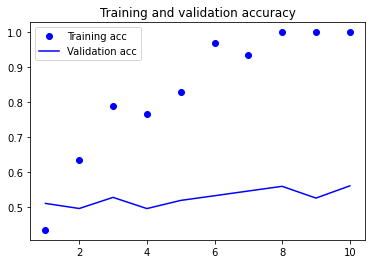

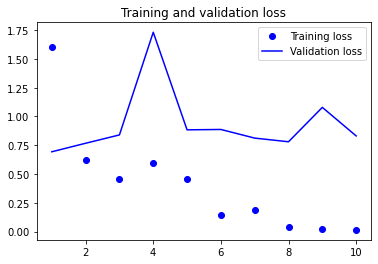

In [15]:
import matplotlib.pyplot as plt
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

# Training the same model without pretrained word embeddings

In [16]:
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=maxlen))
model.add(Flatten())
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 100)          1000000   
_________________________________________________________________
flatten_2 (Flatten)          (None, 10000)             0         
_________________________________________________________________
dense_3 (Dense)              (None, 32)                320032    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 1,320,065
Trainable params: 1,320,065
Non-trainable params: 0
_________________________________________________________________


In [17]:
model.compile(optimizer='rmsprop',
loss='binary_crossentropy',
metrics=['acc'])


history = model.fit(x_train, y_train,
epochs=10,
batch_size=32,
validation_data=(x_val, y_val))

C:\Users\92324\Anaconda\envs\tensorflow\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 10000 samples
Epoch 1/10
200/200 [==============================] - 1s 5ms/step - loss: 0.6988 - acc: 0.4550 - val_loss: 0.6938 - val_acc: 0.5037
Epoch 2/10
200/200 [==============================] - 1s 4ms/step - loss: 0.5012 - acc: 0.9900 - val_loss: 0.6963 - val_acc: 0.5120
Epoch 3/10
200/200 [==============================] - 1s 4ms/step - loss: 0.2871 - acc: 0.9850 - val_loss: 0.6968 - val_acc: 0.5181
Epoch 4/10
200/200 [==============================] - 1s 4ms/step - loss: 0.1230 - acc: 1.0000 - val_loss: 0.7024 - val_acc: 0.5178
Epoch 5/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0564 - acc: 1.0000 - val_loss: 0.7086 - val_acc: 0.5169
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0288 - acc: 1.0000 - val_loss: 0.7150 - val_acc: 0.5163
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0160 - acc: 1.0000 - val_loss: 0.7188 - val_acc: 0.5185
Epoch 8/10
200/200 [========

# Tokenizing the data of the test set

In [21]:
test_dir = os.path.join(imdb_dir, 'test')
labels = []
texts = []
for label_type in ['neg', 'pos']:
    dir_name = os.path.join(test_dir, label_type)
    for fname in sorted(os.listdir(dir_name)):
        if fname[-4:] == '.txt':
            f = open(os.path.join(dir_name, fname) , encoding="utf8")
            texts.append(f.read())
            f.close()
            if label_type == 'neg':
                labels.append(0)
            else:
                labels.append(1)

In [22]:
sequences = tokenizer.texts_to_sequences(texts)
x_test = pad_sequences(sequences, maxlen=maxlen)
y_test = np.asarray(labels)

#  Evaluating the model on the test set

In [23]:
model.load_weights('pre_trained_glove_model.h5')
model.evaluate(x_test, y_test)


25000/25000 [==============================] - 2s 62us/step


[0.8150547177696228, 0.5660799741744995]